# Application of Fuzz Logic in Stock Trading

This notebook explores fuzzy logic in its application in stock trading. The data that was used in this notebook were historical stock price data of publicly listed compnies in the Philippines.

In [1]:
# import libraries
from re import X
import numpy as np
import pandas as pd
import ta
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

                Close       Open       High        Low   Volume
Date                                                           
1986-01-02   172.6575   172.6575   172.6575   172.6575    600.0
1986-01-03   172.6575   172.6575   172.6575   172.6575   1900.0
1986-01-06   175.4879   175.4879   175.4879   175.4879   2800.0
1986-01-07   181.1488   175.4879   181.1488   175.4879   3200.0
1986-01-09   181.1488   181.1488   181.1488   181.1488   2600.0
...               ...        ...        ...        ...      ...
2023-09-12  1781.0000  1786.0000  1809.0000  1781.0000  12985.0
2023-09-13  1787.0000  1799.0000  1799.0000  1781.0000  16850.0
2023-09-14  1795.0000  1795.0000  1795.0000  1782.0000  12070.0
2023-09-15  1752.0000  1795.0000  1810.0000  1752.0000  29105.0
2023-09-18  1752.0000  1789.0000  1789.0000  1752.0000  27225.0

[8861 rows x 5 columns]


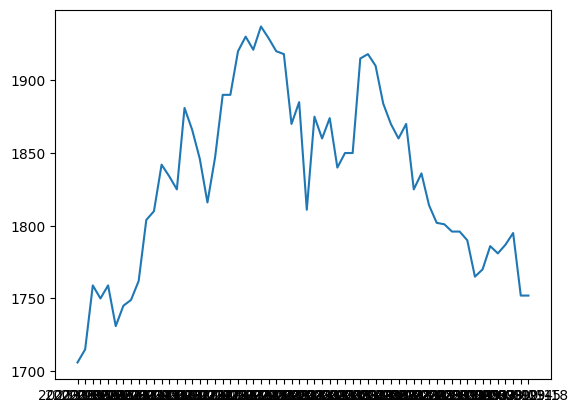

In [2]:
# read and print sample historical stock price data
series = pd.read_csv('../Data/PH-historical-stock-price-data-csv/GLO.csv', header = 0, index_col = 'Date')
print(series)

# plot historical stock price data
fig, ax = plt.subplots()    
ax.plot(series['Close'].tail(60))

In [3]:
def trimf(val, vector):
    """
    Triangular membership function
    
    This function calculates the fuzzy value of a crisp input
    
    a <= b <= c
    
    Args
    ----
    
    val:
        crisp value to be fuzzified
        
    vector:
        values of the left base, peak, and right of the triangular membership function
        
    Returns
    -------
        fuzzified value from the crisp value
    """
    
    
    assert len(vector) == 3, "the length of the vector must be equal to 3"
    
    a, b, c = vector
    assert a <= b, "a must be less than or equal to b"
    assert b <= c, "b must be less than or equal to c"
    
    if val <= a:
        return 0
    elif (val >= a) and (val <= b):
        return (val - a)/(b - a)
    elif (val >= b) and (val <= c):
        return (c - val)/(c - b) 
    elif val >= c:
        return 0        

In [4]:
def linearf(val, vector, positive_slope = True):
    """
    a <= b
    
    Parameters
    ----------
    
    val:
        The value to be fuzzified
        
    vector:
        A length 2 vector that defines the linear boundaries of the 
        linear membership function
    
    positive slope:

        
    Returns
    -------
        The fuzzified value from the crisp input
    """
    
    
    assert len(vector) == 2, "The vector must of of length 2"
    
    a, b = vector
    assert a<=b, "a must be less than or equal to be"
    
    if positive_slope:
       if val < a:
           return 0
       elif val > b:
           return 1
       else:
           return (val - a)/(b - a)
    else:
       if val < a:
           return 1
       elif val > b:
           return 0
       else:
           return (b - val)/(b - a) 

In [5]:
class fuzzy_TA:
    def __init__(self, df):
        self.df = df
        self.u = pd.DataFrame()
        self.z = pd.DataFrame()
        self.u_sum = pd.DataFrame()
        self.z_sum = pd.DataFrame()
    
    # MOMENTUM INDICATORS
    
    def RSI(self, window = 14, fillna = False, p0 = 0, p1 = 1):
        """
        Relative Stregth Index
    
        Parameters
        ----

        window:
            the window or number of elements to be included in the calculation
        
        p0:
            the constant to be passed in the consequent of the TSK model
        
        p1:
            the first order value to be passed in the consequent of the TSK model
        
        Returns
        ------
            None
        
        """
        
        # print(f'\n{ticker}')
        
        # compute for the RSI of the stock
        self.df[f'RSI{window}'] = (ta.momentum.RSIIndicator(
            close = self.df['Close'],
            window = window,
            fillna = fillna)
            .rsi()
        )
        
        # compute for the membership values of the RSI values
        self.u[f'RSI{window}_lo'] = self.df[f'RSI{window}'].apply(lambda x: linearf(x, [0, 50], positive_slope = False))
        self.u[f'RSI{window}_md'] = self.df[f'RSI{window}'].apply(lambda x: trimf(x, [0, 50, 100])) 
        self.u[f'RSI{window}_hi'] = self.df[f'RSI{window}'].apply(lambda x: linearf(x, [50, 100], positive_slope = True))
        
        # the following are the fuzzy rules for RSI
        # if RSI is low, then buy
        self.z[f'RSI{window}_lo'] = p0 + (p1 * ((self.u[f'RSI{window}_lo'] * 25)  + 75))
        
        # # if RSI is medium, then hold
        mask = (self.df[f'RSI{window}'] < 50)
        self.z.loc[mask, f'RSI{window}_md'] = p0 + (p1 * ((self.u[f'RSI{window}_md'] * -25) + 75))
        
        mask = (self.df[f'RSI{window}'] > 50)
        self.z.loc[mask, f'RSI{window}_md'] = p0 + (p1 * ((self.u[f'RSI{window}_md'] * 25) + 25))

        # if RSI is high then sell
        self.z[f'RSI{window}_hi'] = p0 + (p1 * ((self.u[f'RSI{window}_hi'] * -25) + 25))
        
    def StochRSI(self, window = 14, smooth1 = 3, smooth2 = 3, fillna = False, p0 = 0, p1 = 1):
        """
        Stochastic RSI
        
        Parameters
        ----------
        
        Returns
        -------
            None
        
        """
        
        self.df[f'StochRSI{window}'] = (
            ta.momentum.StochRSIIndicator(
                close = self.df['Close'],
                window = window,
                smooth1 = smooth1,
                smooth2 = smooth2,
                fillna = fillna)
            .stochrsi_d()
        )

        # calculate the membership values for low, medium and high RSI
        self.u[f'StochRSI{window}_lo'] = self.df[f'StochRSI{window}'].apply(lambda x: linearf(x, [0, 0.2], positive_slope = False))
        self.u[f'StochRSI{window}_md'] = self.df[f'StochRSI{window}'].apply(lambda x: trimf(x, [0, 0.5, 1])) 
        self.u[f'StochRSI{window}_hi'] = self.df[f'StochRSI{window}'].apply(lambda x: linearf(x, [0.8, 1], positive_slope = True))
        
        # the following are the fuzzy rules for StochRSI
        # if StochRSI is low, then buy
        self.z[f'StochRSI{window}_lo'] = p0 + (p1 * ((self.u[f'StochRSI{window}_lo'] * 25)  + 75))
        
        # if StochRSI is medium and StochRSI is less than 0.5, then buy
        mask = (self.df[f'StochRSI{window}'] < 0.5)
        self.z.loc[mask, f'StochRSI{window}_md'] = p0 + (p1 * ((self.u[f'StochRSI{window}_md'] * -25) + 75))
        
        # if StochRSI is medium and StochRSI is more than 0.5, then sell
        mask = (self.df[f'StochRSI{window}'] > 0.5)
        self.z.loc[mask, f'StochRSI{window}_md'] = p0 + (p1 * ((self.u[f'StochRSI{window}_md'] * 25) + 25))

        # if StochRSI is high then sell
        self.z[f'StochRSI{window}_hi'] = p0 + (p1 * ((self.u[f'StochRSI{window}_hi'] * -25) + 25))

    def StochRSI_KxD(self, window = 14, smooth1 = 1, smooth2 =3, fillna = False, weekly = False, monthly = False, p0 = 0, p1 = 1):
        """
        Stochastic RSI
        
            This method computes for the stochastic RSI 
            k is the slow indicator
            d is the fast indicator
        
        Parameters
        ----
        
        window: int
            The window used in the computation
            
        smooth1: int
            first smoothing factor
            
        smooth2: int
            second smoothing factor
            
        fillna: boolean

        
        Returns
        ------
            None
        

        """
        
        self.df[f'StochRSI_d{window}'] = (
            ta.momentum.StochRSIIndicator(
                close = self.df['Close'],
                window = window,
                smooth1 = smooth1,
                smooth2 = smooth2,
                fillna = fillna)
            .stochrsi_d()
        )
        
        self.df[f'StochRSI_k{window}'] = (
            ta.momentum.StochRSIIndicator(
                close = self.df['Close'],
                window = window,
                smooth1 = smooth1,
                smooth2 = smooth2,
                fillna = fillna)
            .stochrsi_k()
        )
        
        # compute for the KxD difference
        KxD_diff =  self.df[f'StochRSI_k{window}'] - self.df[f'StochRSI_d{window}']
        
        # calculate the membership values for low, medium and high RSI
        self.u[f'StochRSI_KxD{window}_neg'] = KxD_diff.apply(lambda x: linearf(x, [-0.10, 0], positive_slope = False))
        self.u[f'StochRSI_KxD{window}_zero'] = KxD_diff.apply(lambda x: trimf(x, [-0.10, 0, 0.10])) 
        self.u[f'StochRSI_KxD{window}_pos'] = KxD_diff.apply(lambda x: linearf(x, [0, 0.10], positive_slope = True))
        
        # the following are the fuzzy rules for PPO
        # if PPO_hist is postive then buy
        self.z[f'StochRSI_KxD{window}_pos'] = p0 + (p1 * ((self.u[f'StochRSI_KxD{window}_pos'] * 25) + 75))
        
        # if PPO_hist is zero
        mask = (KxD_diff > 0)
        # if KxD_diff is above 0, then lean towards buying
        self.z.loc[mask, f'StochRSI_KxD{window}_zero'] = p0 + (p1 * ((self.u[f'StochRSI_KxD{window}_zero'] * -25) + 75))

        mask = (KxD_diff <= 0)
        # if KxD_diff is less than or equal to  0, then lean towards selling
        self.z.loc[mask, f'StochRSI_KxD{window}_zero'] = p0 + (p1 * ((self.u[f'StochRSI_KxD{window}_zero'] * 25) + 25))

        # if KxD_diff is negative then sell
        self.z[f'StochRSI_KxD{window}_neg'] = p0 + (p1 * ((self.u[f'StochRSI_KxD{window}_neg'] * -25) + 25))
        
    def WilliamsR(self, window = 14, fillna = False, p0 = 0, p1 = 1):
        """
        Compute for the williams R 
        
        Parameters
        ----------
        
        Returns
        -------
            None
        
        """
        # compute for Williams % R
        self.df[f'WilliamsR{window}'] = (
            ta.momentum.WilliamsRIndicator(
                high = self.df['High'],
                low = self.df['Low'],
                close = self.df['Close'],
                lbp = window,
                fillna = fillna)
            .williams_r()
        )

        # calculate the membership values for low, medium and high RSI
        self.u[f'WilliamsR{window}_lo'] = self.df[f'WilliamsR{window}'].apply(lambda x: linearf(x, [-100, -80], positive_slope = False))
        self.u[f'WilliamsR{window}_md'] = self.df[f'WilliamsR{window}'].apply(lambda x: trimf(x, [-100, -50, 0])) 
        self.u[f'WilliamsR{window}_hi'] = self.df[f'WilliamsR{window}'].apply(lambda x: linearf(x, [-20, 0], positive_slope = True))
        
        # the following are the fuzzy rules for StochRSI
        # if StochRSI is low, then buy
        self.z[f'WilliamsR{window}_lo'] = p0 + (p1 * ((self.u[f'WilliamsR{window}_lo'] * 25)  + 75))
        
        # if StochRSI is medium and StochRSI is less than 0.5, then buy
        mask = (self.df[f'WilliamsR{window}'] < -50)
        self.z.loc[mask, f'WilliamsR{window}_md'] = p0 + (p1 * ((self.u[f'WilliamsR{window}_md'] * -25) + 75))
        
        # if StochRSI is medium and StochRSI is more than 0.5, then sell
        mask = (self.df[f'WilliamsR{window}'] >= -50)
        self.z.loc[mask, f'WilliamsR{window}_md'] = p0 + (p1 * ((self.u[f'WilliamsR{window}_md'] * 25) + 25))

        # if StochRSI is high then sell
        self.z[f'WilliamsR{window}_hi'] = p0 + (p1 * ((self.u[f'WilliamsR{window}_hi'] * -25) + 25))

    def Ultimate(self, window1 = 7, window2 = 14, window3 = 28, weight1 = 4.0, weight2 = 2.0, weight3 = 1.0, fillna = False, p0 = 0, p1 = 1):
        """
        Ultiimate oscilator
        
        Parameters
        ----------
        
        Returns
        -------
            None
        
        """
        
        # compute for the Ultimate oscillator
        self.df[f'Ultimate{window1}'] = ta.momentum.ultimate_oscillator(
            high = self.df['High'], 
            low = self.df['Low'], 
            close = self.df['Close'], 
            window1 = window1, 
            window2 = window2, 
            window3 = window3, 
            weight1 = weight1, 
            weight2 = weight2, 
            weight3 = weight3, 
            fillna = fillna)
    
        # calculate the membership values for low, medium and high ultimate oscillator
        self.u[f'Ultimate{window1}_lo'] = self.df[f'Ultimate{window1}'].apply(lambda x: linearf(x, [0, 20], positive_slope = False))
        self.u[f'Ultimate{window1}_md'] = self.df[f'Ultimate{window1}'].apply(lambda x: trimf(x, [0, 50, 100])) 
        self.u[f'Ultimate{window1}_hi'] = self.df[f'Ultimate{window1}'].apply(lambda x: linearf(x, [80, 100], positive_slope = True))
        
        # the following are the fuzzy rules for ultimate oscillator
        # if ultimate is low, then buy
        self.z[f'Ultimate{window1}_lo'] = p0 + (p1 * ((self.u[f'Ultimate{window1}_lo'] * 25)  + 75))
        
        # if ultimate is medium and ultimate is below 50 then do this; borderlining to buying
        mask = (self.df[f'Ultimate{window1}'] < 50)
        self.z.loc[mask, f'Ultimate{window1}_md'] = p0 + (p1 * ((self.u[f'Ultimate{window1}_md'] * -25) + 75))
        
        # if ultimate is medium and ultimate is above or equal to  50 then do this; borderlining to selling
        mask = (self.df[f'Ultimate{window1}'] >= 50)
        self.z.loc[mask, f'Ultimate{window1}_md'] = p0 + (p1 * ((self.u[f'Ultimate{window1}_md'] * 25) + 25))

        # if ultimate is high then sell
        self.z[f'Ultimate{window1}_hi'] = p0 + (p1 * ((self.u[f'Ultimate{window1}_hi'] * -25) + 25))

    def TSI(self, window_slow = 25, window_fast = 13, fillna= False, p0 = 0, p1 = 1):
        """
        True Strength Index
        
        Parameters
        ----------
        window_slow:

        window_fast:
        
        fillna:
        
        Returns
        -------        
            None
        """

        # compute for the TSI of the stock
        self.df[f'TSI{window_slow}x{window_fast}'] = (ta.momentum.tsi(
            close = self.df['Close'],
            window_slow = 25,
            window_fast = 13,
            fillna = False)
        )

        # calculate the membership values for low, medium and high ultimate oscillator
        self.u[f'TSI{window_slow}x{window_fast}_lo'] = self.df[f'TSI{window_slow}x{window_fast}'].apply(lambda x: linearf(x, [-0.5, -0.25], positive_slope = False))
        self.u[f'TSI{window_slow}x{window_fast}_md'] = self.df[f'TSI{window_slow}x{window_fast}'].apply(lambda x: trimf(x, [-0.5, 0, 0.5])) 
        self.u[f'TSI{window_slow}x{window_fast}_hi'] = self.df[f'TSI{window_slow}x{window_fast}'].apply(lambda x: linearf(x, [0.25, 0.5], positive_slope = True))


        # the following are the fuzzy rules for ultimate oscillator
        # if TSI is low, then buy
        self.z[f'TSI{window_slow}x{window_fast}_lo'] = p0 + (p1 * ((self.u[f'TSI{window_slow}x{window_fast}_lo'] * 25)  + 75))
        
        # if TSI is medium, then hold
        self.z[f'TSI{window_slow}x{window_fast}_md'] = p0 + (p1 * (50))

        # if TSI is high then sell
        self.z[f'TSI{window_slow}x{window_fast}_hi'] = p0 + (p1 * ((self.u[f'TSI{window_slow}x{window_fast}_hi'] * -25) + 25))


    # VOLUME INDICATORS

    def CMF(self, window = 20, fillna = False, weekly = False, monthly = False, p0 = 0, p1 = 1):
        """
        Chaikin Money Flow
        
        Parameters
        ----------
        
        Returns
        -------
        None
        
        
        """
        
        
        self.df[f'CMF{window}'] = (
            ta.volume.chaikin_money_flow(
                high = self.df['High'], 
                low = self.df['Low'], 
                close = self.df['Close'], 
                volume = self.df['Volume'], 
                window = window, 
                fillna = fillna)
            )

        CMF_val = self.df[f'CMF{window}'].iloc[-1]
        
        # calculate the membership values for low, medium and high CMF
        self.u[f'CMF{window}_lo'] = self.df[f'CMF{window}'].apply(lambda x: linearf(x, [-1, 0], positive_slope = False))
        self.u[f'CMF{window}_md'] = self.df[f'CMF{window}'].apply(lambda x: trimf(x, [-1, 0, 1])) 
        self.u[f'CMF{window}_hi'] = self.df[f'CMF{window}'].apply(lambda x: linearf(x, [0, 1], positive_slope = True))        
        
        # the following are the fuzzy rules for CMF
        # if CMF_val is negative then buy
        self.z[f'CMF{window}_lo'] = p0 + (p1 * ((self.u[f'CMF{window}_lo'] * 25)  + 75))
        
        # if CMF is medium and ultimate is below 0 then do this; borderlining to buying
        mask = (self.df[f'CMF{window}'] < 0)
        self.z.loc[mask, f'CMF{window}_md'] = p0 + (p1 * ((self.u[f'CMF{window}_md'] * -25) + 75))
        
        # if CMF is medium and ultimate is above or equal to  0 then do this; borderlining to selling
        mask = (self.df[f'CMF{window}'] >= 0)
        self.z.loc[mask, f'CMF{window}_md'] = p0 + (p1 * ((self.u[f'CMF{window}_md'] * 25) + 25))

        # if CMF is high then sell
        self.z[f'CMF{window}_hi'] = p0 + (p1 * ((self.u[f'CMF{window}_hi'] * -25) + 25))
        
    def MFI(self, window = 14, fillna = False, weekly = False, monthly = False, p0 = 0, p1 = 1):
        """
        Money Flow Index
        
        Parameters
        ----------
        
        Returns
        -------
        None
        
        
        """
        # calculate the money flow index for the window
        self.df[f'MFI{window}'] = (
            ta.volume.MFIIndicator(
                high = self.df['High'], 
                low = self.df['Low'], 
                close = self.df['Close'], 
                volume = self.df['Volume'], 
                window = window, 
                fillna = fillna)
            .money_flow_index()
        )
        
        # calculate the membership values for low, medium and high MFI
        self.u[f'MFI{window}_lo'] = self.df[f'MFI{window}'].apply(lambda x: linearf(x, [0, 20], positive_slope = False))
        self.u[f'MFI{window}_md'] = self.df[f'MFI{window}'].apply(lambda x: trimf(x, [0, 50, 100])) 
        self.u[f'MFI{window}_hi'] = self.df[f'MFI{window}'].apply(lambda x: linearf(x, [80, 100], positive_slope = True))


        # the following are the fuzzy rules for MFI
        # if CMF_val is negative then buy
        self.z[f'MFI{window}_lo'] = p0 + (p1 * ((self.u[f'MFI{window}_lo'] * 25)  + 75))
        
        # if CMF is medium and ultimate is below 0 then do this; borderlining to buying
        mask = (self.df[f'MFI{window}'] < 0)
        self.z.loc[mask, f'MFI{window}_md'] = p0 + (p1 * ((self.u[f'MFI{window}_md'] * -25) + 75))
        
        # if CMF is medium and ultimate is above or equal to  0 then do this; borderlining to selling
        mask = (self.df[f'MFI{window}'] >= 0)
        self.z.loc[mask, f'MFI{window}_md'] = p0 + (p1 * ((self.u[f'MFI{window}_md'] * 25) + 25))

        # if CMF is high then sell
        self.z[f'MFI{window}_hi'] = p0 + (p1 * ((self.u[f'MFI{window}_hi'] * -25) + 25))
            
    def RSI_OBV(self, window = 14, fillna = False, weekly = False, monthly = False, p0 = 0, p1 = 1):
        """
        Relative Stregth Index as applied on the On Balance Volume
        
    
        Parameters
        ----
        window:
            The window 
        
        p0:
            The constant to be passed in the consequent of the TSK model
        
        p1:
            The first order value to be passed in the consequent of the TSK model
        
        Returns
        ------
            None
        
        """

        # compute for OBV
        self.df['OBV'] = (
            ta.volume.OnBalanceVolumeIndicator(
                close = self.df['Close'], 
                volume = self.df['Volume'], 
                fillna = False)
            .on_balance_volume()
        )

        # normalize OBV
        volume_sum = self.df['OBV'].sum()
        self.df['OBV'] = (self.df['OBV']/volume_sum)*100

        # compute for the RSI of the stock
        self.df[f'RSI_OBV{window}'] = (
            ta.momentum.RSIIndicator(
                close = self.df['OBV'], 
                window = window, 
                fillna = fillna)
            .rsi()
        )
        
        # calculate the membership values for low, medium and high RSI_OBV
        self.u[f'RSI_OBV{window}_lo'] = self.df[f'RSI_OBV{window}'].apply(lambda x: linearf(x, [0, 20], positive_slope = False))
        self.u[f'RSI_OBV{window}_md'] = self.df[f'RSI_OBV{window}'].apply(lambda x: trimf(x, [0, 50, 100])) 
        self.u[f'RSI_OBV{window}_hi'] = self.df[f'RSI_OBV{window}'].apply(lambda x: linearf(x, [80, 100], positive_slope = True))
        
        # the following are the fuzzy rules for RSI_OBV
        # if RSI_OBV is low then buy
        self.z[f'RSI_OBV{window}_lo'] = p0 + (p1 * ((self.u[f'RSI_OBV{window}_lo'] * 25)  + 75))
        
        # if RSI_OBV is medium and RSI_OBV is below 50 then do this; borderlining to buying
        mask = (self.df[f'RSI_OBV{window}'] < 50)
        self.z.loc[mask, f'RSI_OBV{window}_md'] = p0 + (p1 * ((self.u[f'RSI_OBV{window}_md'] * -25) + 75))
        
        # if RSI_OBV is medium and RSI_OBV is above or equal to  50 then do this; borderlining to selling
        mask = (self.df[f'RSI_OBV{window}'] >= 50)
        self.z.loc[mask, f'RSI_OBV{window}_md'] = p0 + (p1 * ((self.u[f'RSI_OBV{window}_md'] * 25) + 25))

        # if RSI_OBV is high then sell
        self.z[f'RSI_OBV{window}_hi'] = p0 + (p1 * ((self.u[f'RSI_OBV{window}_hi'] * -25) + 25))
    
    def StochOBV_KxD(self, window = 14, smooth1 = 1, smooth2 =3, fillna = False, p0 = 0, p1 = 1):
        """
        Stochastic OBV
        
            This method computes for the stochastic OBV 
            k is the slow indicator
            d is the fast indicator
        
        Parameters
        ----
        
        window: int
            The window used in the computation
            
        smooth1: int
            first smoothing factor
            
        smooth2: int
            second smoothing factor
            
        fillna: boolean
        
        Returns
        ------
            None
        
        """
        
        # compute for OBV
        self.df['OBV'] = (
            ta.volume.OnBalanceVolumeIndicator(
                close = self.df['Close'], 
                volume = self.df['Volume'], 
                fillna = False)
            .on_balance_volume()
        )

        # normalize OBV
        volume_sum = self.df['OBV'].sum()
        self.df['OBV'] = (self.df['OBV']/volume_sum)*100
        
        # compute for the stochastic of OBV
        self.df[f'StochOBV_d{window}'] = (
            ta.momentum.StochRSIIndicator(
                close = self.df['OBV'],
                window = window,
                smooth1 = smooth1,
                smooth2 = smooth2,
                fillna = fillna)
            .stochrsi_d()
        )
        self.df[f'StochOBV_k{window}'] = (
            ta.momentum.StochRSIIndicator(
                close = self.df['OBV'],
                window = window,
                smooth1 = smooth1,
                smooth2 = smooth2,
                fillna = fillna)
            .stochrsi_k()
        )
        
        # compute for the KxD difference
        KxD_diff =  self.df[f'StochOBV_k{window}'] - self.df[f'StochOBV_d{window}']

        # calculate the membership values for low, medium and high RSI
        self.u[f'StochOBV_KxD{window}_neg'] = KxD_diff.apply(lambda x: linearf(x, [-0.4, 0], positive_slope = False))
        self.u[f'StochOBV_KxD{window}_zero'] = KxD_diff.apply(lambda x: trimf(x, [-0.4, 0, 0.4])) 
        self.u[f'StochOBV_KxD{window}_pos'] = KxD_diff.apply(lambda x: linearf(x, [0, 0.4], positive_slope = True))
        
        # the following are the fuzzy rules for PPO
        # if PPO_hist is postive then buy
        self.z[f'StochOBV_KxD{window}_pos'] = p0 + (p1 * ((self.u[f'StochOBV_KxD{window}_pos'] * 25) + 75))
        
        # if PPO_hist is zero
        mask = (KxD_diff > 0)
        # if KxD_diff is above  0, then lean towards buying
        self.z.loc[mask, f'StochOBV_KxD{window}_zero'] = p0 + (p1 * ((self.u[f'StochOBV_KxD{window}_zero'] * -25) + 75))

        mask = (KxD_diff <= 0)
        # if KxD_diff is less than or equal to  0, then lean towards selling
        self.z.loc[mask, f'StochOBV_KxD{window}_zero'] = p0 + (p1 * ((self.u[f'StochOBV_KxD{window}_zero'] * 25) + 25))

        # if KxD_diff is negative then sell
        self.z[f'StochOBV_KxD{window}_neg'] = p0 + (p1 * ((self.u[f'StochOBV_KxD{window}_neg'] * -25) + 25))
        
    # VOLATILITY INDICATORS
    def BB_pband(self, window = 20, window_dev = 2, fillna = False, weekly = False, monthly = False, p0 = 0, p1 = 1):
        """
        Bolinger percentage band
        
        Parameters
        ----------
        
        Returns
        -------
            None
        
        """
        
        self.df[f'BB_pband{window}'] = (ta.volatility.bollinger_pband(
            close = self.df['Close'], 
            window = window, 
            window_dev = window_dev, 
            fillna = fillna)
        )

        
        # calculate the membership values for low, medium and high RSI
        self.u[f'BB_pband{window}_lo'] = self.df[f'BB_pband{window}'].apply(lambda x: linearf(x, [-0.2, 0], positive_slope = False))
        self.u[f'BB_pband{window}_md'] = self.df[f'BB_pband{window}'].apply(lambda x: trimf(x, [0, 0.5, 1])) 
        self.u[f'BB_pband{window}_hi'] = self.df[f'BB_pband{window}'].apply(lambda x: linearf(x, [1, 1.2], positive_slope = True))
        

        # the following are the fuzzy rules for BB_pband
        # if BB_pband is low then buy
        self.z[f'BB_pband{window}_lo'] = p0 + (p1 * ((self.u[f'BB_pband{window}_lo'] * 25) + 75))
        
        # if BB_pband is low
        mask = self.df[f'BB_pband{window}'] < 0
        # if BB_pband is less than 0, then lean towards buying
        self.z.loc[mask, f'BB_pband{window}_md'] = p0 + (p1 * ((self.u[f'BB_pband{window}_md'] * -25) + 75))

        mask = self.df[f'BB_pband{window}'] >= 0
        # if BB_pband is greater than or equal to  0, then lean towards selling
        self.z.loc[mask, f'BB_pband{window}_md'] = p0 + (p1 * ((self.u[f'BB_pband{window}_md'] * 25) + 25))

        # if BB_pband is high then sell
        self.z[f'BB_pband{window}_hi'] = p0 + (p1 * ((self.u[f'BB_pband{window}_hi'] * -25) + 25))
        
    # TREND INDICATORS
    
    def MACD(self, window_fast = 12, window_slow = 26, window_sign = 9, fillna = False, p0 = 0, p1 = 1):
        
        # compute for MACD Line
        self.df[f'MACD{window_fast}_{window_slow}_line'] = (
            ta.trend.MACD(
                close = self.df['Close'], 
                window_fast = window_fast,
                window_slow = window_slow,
                window_sign = window_sign, 
                fillna = False)
            .macd()
        )
        
        # compute for MACD Difference
        self.df[f'MACD{window_fast}_{window_slow}_diff'] = (
            ta.trend.MACD(
                close = self.df['Close'], 
                window_fast = window_fast,
                window_slow = window_slow,
                window_sign = window_sign, 
                fillna = False)
            .macd_diff()
        )
        
        # compute for MACD signal
        self.df[f'MACD{window_fast}_{window_slow}_signal'] = (
            ta.trend.MACD(
                close = self.df['Close'], 
                window_fast = window_fast,
                window_slow = window_slow,
                window_sign = window_sign, 
                fillna = False)
            .macd_signal()
        )
        self.u = pd.DataFrame(index = self.df.index )
        self.z = pd.DataFrame(index = self.df.index )
 
        # crude implementation of the MACD rule
        mask = (self.df[f'MACD{window_fast}_{window_slow}_signal'] < self.df[f'MACD{window_fast}_{window_slow}_line'])
        self.u.loc[mask, f'MACD{window_fast}_{window_slow}_lo'] = 0
        self.u.loc[mask, f'MACD{window_fast}_{window_slow}_hi'] = 1
        self.z.loc[mask, f'MACD{window_fast}_{window_slow}_lo'] = 0
        self.z.loc[mask, f'MACD{window_fast}_{window_slow}_hi'] = 100
        
        mask = (self.df[f'MACD{window_fast}_{window_slow}_signal'] > self.df[f'MACD{window_fast}_{window_slow}_line'])
        self.u.loc[mask, f'MACD{window_fast}_{window_slow}_lo'] = 1
        self.u.loc[mask, f'MACD{window_fast}_{window_slow}_hi'] = 0
        self.z.loc[mask, f'MACD{window_fast}_{window_slow}_lo'] = 0
        self.z.loc[mask, f'MACD{window_fast}_{window_slow}_hi'] = 100
    def CCI(self, window = 20, constant = 0.0015, fillna = False, weekly = False, monthly = False, p0 = 0, p1 = 1):
        """
        Compute for the commodity channel index
        """
        # compute for the commodity channel index
        self.df[f'CCI{window}'] = (
            ta.trend.CCIIndicator(
                high = self.df['High'],
                low = self.df['Low'],
                close = self.df['Close'],
                window = window,
                constant = constant,
                fillna = fillna)
            .cci()
        )

    
        # calculate the membership values for low, medium and high CCI
        self.u[f'CCI{window}_lo'] = self.df[f'CCI{window}'].apply(lambda x: linearf(x, [-200, -100], positive_slope = False))
        self.u[f'CCI{window}_md'] = self.df[f'CCI{window}'].apply(lambda x: trimf(x, [-200, 0, 200])) 
        self.u[f'CCI{window}_hi'] = self.df[f'CCI{window}'].apply(lambda x: linearf(x, [100, 200], positive_slope = True))
        
        # the following are the fuzzy rules for CCI
        # if BB_pband is low then buy
        self.z[f'CCI{window}_lo'] = p0 + (p1 * ((self.u[f'CCI{window}_lo'] * 25) + 75))
        
        # if CCI is low
        mask = self.df[f'CCI{window}'] < 0
        # if CCI is less than 0, then lean towards buying
        self.z.loc[mask, f'CCI{window}_md'] = p0 + (p1 * ((self.u[f'CCI{window}_md'] * -25) + 75))

        mask = self.df[f'CCI{window}'] >= 0
        # if CCI is greater than or equal to  0, then lean towards selling
        self.z.loc[mask, f'CCI{window}_md'] = p0 + (p1 * ((self.u[f'CCI{window}_md'] * 25) + 25))

        # if CCI is high then sell
        self.z[f'CCI{window}_hi'] = p0 + (p1 * ((self.u[f'CCI{window}_hi'] * -25) + 25))
    
    def STC(self, window_slow = 50, window_fast = 30, cycle = 30, smooth1 = 3, smooth2 = 3, fillna = False, weekly = False, monthly = False, p0 = 0, p1 = 1, ticker = 'ticker'):
        """
        Schaff Trend Cycle
        
        Parameters
        ----------
        
        Returns
        -------
            None
        
        """
        
        self.df[f'STC{window_slow}'] = (
            ta.trend.STCIndicator(
                close = self.df['Close'],
                window_slow = window_slow,
                window_fast = window_fast,
                cycle = cycle,
                smooth1 = smooth1,
                smooth2 = smooth2,
                fillna = fillna)
            .stc()
        )
        
        # calculate the membership values for low, medium and high CCI
        self.u[f'STC{window_slow}_lo'] = self.df[f'STC{window_slow}'].apply(lambda x: linearf(x, [0, 20], positive_slope = False))
        self.u[f'STC{window_slow}_md'] = self.df[f'STC{window_slow}'].apply(lambda x: trimf(x, [0, 50, 100])) 
        self.u[f'STC{window_slow}_hi'] = self.df[f'STC{window_slow}'].apply(lambda x: linearf(x, [80, 100], positive_slope = True))
        
        # the following are the fuzzy rules for CCI
        # if BB_pband is low then buy
        self.z[f'STC{window_slow}_lo'] = p0 + (p1 * ((self.u[f'STC{window_slow}_lo'] * 25) + 75))
        
        # if CCI is low
        mask = self.df[f'STC{window_slow}'] < 50
        # if CCI is less than 0, then lean towards buying
        self.z.loc[mask, f'STC{window_slow}_md'] = p0 + (p1 * ((self.u[f'STC{window_slow}_md'] * -25) + 75))

        mask = self.df[f'STC{window_slow}'] >= 50
        # if CCI is greater than or equal to  0, then lean towards selling
        self.z.loc[mask, f'STC{window_slow}_md'] = p0 + (p1 * ((self.u[f'STC{window_slow}_md'] * 25) + 25))

        # if CCI is high then sell
        self.z[f'STC{window_slow}_hi'] = p0 + (p1 * ((self.u[f'STC{window_slow}_hi'] * -25) + 25))
        
    def PSAR(self, step = 0.02, max_step = 0.2, fillna = False, weekly = False, monthly = False, p0 = 0, p1 = 1):
        """
        Parabolic SAR
        
        Parameters
        ----------
        
        step:   float
            lorem ipsum
            
        max_step:   float
            lorem ipsum
            
        fillna: bool
            lorem ipsum
        
        p0: float
            lorem ipsum
        
        p1: float
            lorem ipsum
        
        Returns
        -------
        None
        """
        
        # parabolic SAR
        self.df[f'PSAR{step}{max_step}'] = (ta.trend.PSARIndicator(
            high = self.df['High'],
            low = self.df['Low'],
            close = self.df['Close'],
            step = step,
            max_step = max_step,
            fillna = fillna)
            .psar()
        )
        
        self.u = pd.DataFrame(index = self.df.index )
        self.z = pd.DataFrame(index = self.df.index )
 
        # crude implementation of the PSAR rule
        mask = (self.df[f'PSAR{step}{max_step}'] > self.df[f'Close'])
        self.u.loc[mask, f'PSAR{step}{max_step}_lo'] = 0
        self.u.loc[mask, f'PSAR{step}{max_step}_hi'] = 1
        self.z.loc[mask, f'PSAR{step}{max_step}_lo'] = 0
        self.z.loc[mask, f'PSAR{step}{max_step}_hi'] = 100
        
        mask = (self.df[f'PSAR{step}{max_step}'] < self.df[f'Close'])
        self.u.loc[mask, f'PSAR{step}{max_step}_lo'] = 1
        self.u.loc[mask, f'PSAR{step}{max_step}_hi'] = 0
        self.z.loc[mask, f'PSAR{step}{max_step}_lo'] = 0
        self.z.loc[mask, f'PSAR{step}{max_step}_hi'] = 100

    # OTHER INDICATORS
    
    def Fisher_trans(self, window: int = 14, smooth2: int = 3, adjust: bool = True, weekly = False, monthly = False, p0 = 0, p1 = 1):
        """
        Fisher Transform
        
        Parameters
        ----------
        
        Returns
        -------
            None
        
        
        """
        
        np.seterr(divide='ignore')

        med = (self.df['High'] + self.df['Low']) / 2
        ndaylow = med.rolling(window=window).min()
        ndayhigh = med.rolling(window=window).max()
        raw = (2 * ((med - ndaylow) / (ndayhigh - ndaylow))) - 1
        smooth = raw.ewm(span=5, adjust=adjust).mean()
        _smooth = smooth.fillna(0)
        
        self.df[f'Fisher{window}'] = (
            (np.log((1 + _smooth) / (1 - _smooth)))
            .ewm(span=3, adjust=adjust)
            .mean()
        )
        
        # calculate the membership values for low, medium and high Fisher
        self.u[f'Fisher{window}_lo'] = self.df[f'Fisher{window}'].apply(lambda x: linearf(x, [-4, 0], positive_slope = False))
        self.u[f'Fisher{window}_md'] = self.df[f'Fisher{window}'].apply(lambda x: trimf(x, [-2, 0, 2])) 
        self.u[f'Fisher{window}_hi'] = self.df[f'Fisher{window}'].apply(lambda x: linearf(x, [0, 4], positive_slope = True))
        
        # the following are the fuzzy rules for Fisher
        # if Fisher is low, then buy
        self.z[f'Fisher{window}_lo'] = p0 + (p1 * ((self.u[f'Fisher{window}_lo'] * 25)  + 75))
        
        # if Fisher is medium and Fisher is less than 0, then buy
        mask = (self.df[f'Fisher{window}'] < 0)
        self.z.loc[mask, f'Fisher{window}_md'] = p0 + (p1 * ((self.u[f'Fisher{window}_md'] * -25) + 75))
        
        # if Fisher is medium and Fisher is more than 0, then sell
        mask = (self.df[f'Fisher{window}'] >= 0)
        self.z.loc[mask, f'Fisher{window}_md'] = p0 + (p1 * ((self.u[f'Fisher{window}_md'] * 25) + 25))

        # if Fisher is high then sell
        self.z[f'Fisher{window}_hi'] = p0 + (p1 * ((self.u[f'Fisher{window}_hi'] * -25) + 25))
    
    def Fisher_trans_KxD(self, window: int = 14, smooth2: int = 3, adjust: bool = True, weekly = False, monthly = False, p0 = 0, p1 = 1):
        """
        Fisher Transformation Cross
        
        Parameters
        ----------
        
        Returns
        -------
            None
        
        """
        
        np.seterr(divide='ignore')

        med = (self.df['High'] + self.df['Low']) / 2
        ndaylow = med.rolling(window=window).min()
        ndayhigh = med.rolling(window=window).max()
        raw = (2 * ((med - ndaylow) / (ndayhigh - ndaylow))) - 1
        smooth = raw.ewm(span=5, adjust=adjust).mean()
        _smooth = smooth.fillna(0)

        # compute for the k and d smoothed fisher transforms
        fish_series_k = (np.log((1 + _smooth) / (1 - _smooth))).ewm(span=3, adjust=adjust).mean()
        fish_series_d = fish_series_k.rolling(smooth2).mean()
        
        # compute for the KxD difference
        KxD_diff = fish_series_k - fish_series_d
        
        # calculate the membership values for low, medium and high KxD_diff
        self.u[f'Fisher_KxD{window}_neg'] = KxD_diff.apply(lambda x: linearf(x, [-0.25, 0], positive_slope = False))
        self.u[f'Fisher_KxD{window}_zero'] = KxD_diff.apply(lambda x: trimf(x, [-0.13, 0, 0.13])) 
        self.u[f'Fisher_KxD{window}_pos'] = KxD_diff.apply(lambda x: linearf(x, [0, 0.25], positive_slope = True))
        
        # the following are the fuzzy rules for KxD_diff
        # if KxD_diff is postive then buy
        self.z[f'Fisher_KxD{window}_pos'] = p0 + (p1 * ((self.u[f'Fisher_KxD{window}_pos'] * 25) + 75))
        
        # if KxD_diff is zero
        mask = (KxD_diff > 0)
        # if KxD_diff is above 0, then lean towards buying
        self.z.loc[mask, f'Fisher_KxD{window}_zero'] = p0 + (p1 * ((self.u[f'Fisher_KxD{window}_zero'] * -25) + 75))

        mask = (KxD_diff <= 0)
        # if KxD_diff is less than or equal to  0, then lean towards selling
        self.z.loc[mask, f'Fisher_KxD{window}_zero'] = p0 + (p1 * ((self.u[f'Fisher_KxD{window}_zero'] * 25) + 25))

        # if KxD_diff is negative then sell
        self.z[f'Fisher_KxD{window}_neg'] = p0 + (p1 * ((self.u[f'Fisher_KxD{window}_neg'] * -25) + 25))
    
    
    def z_total(self):
        """
        Computes for the total z value for the consequent of the Tsukamoto model
        
        Parameters
        ----------
        
        self
        
        Returns
        -------
        z_total
            the consequent in the Takagi-Sugeno-Kang/Tsukamoto fuzzy inference model
        
        """
        
        self.u_sum['sum'] = self.u.sum(axis = 1)
        
        # initialize z_sum to be 0
        self.z['z_sum'] = 0
        
        # add all values of z across different technical indicator
        for col_name in self.u.columns:
            # produce mask that would remove NANs in the dataframe
            mask = ~(self.z['z_sum'] + (self.z[f'{col_name}'] * self.u[f'{col_name}'])).isna()
            # apply mask
            self.z.loc[mask, 'z_sum'] = self.z['z_sum'] + (self.z[f'{col_name}'] * self.u[f'{col_name}'])
        
        # compute for the normalized z_sum by u_sum
        self.df['z_sum'] = self.z['z_sum'] / self.u_sum['sum']
            
        return 0
    

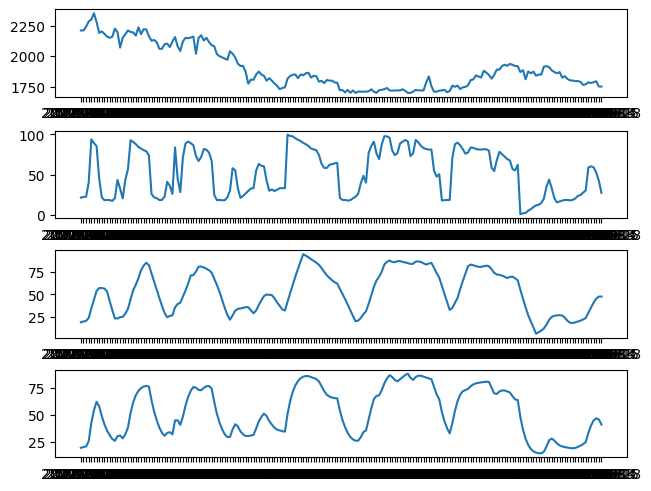

In [6]:
stock = fuzzy_TA(series)

# momentum indicators
stock.RSI()
stock.StochRSI()
stock.StochRSI_KxD(window = 30)
stock.WilliamsR()
stock.Ultimate()
stock.TSI()

# volume indicator
stock.CMF()
stock.MFI()
stock.RSI_OBV()
stock.StochOBV_KxD(window = 30)

# volatility indicator
stock.BB_pband()

# # trend indicators
stock.CCI()
stock.STC()
stock.PSAR()
stock.MACD()

# other indicator
stock.Fisher_trans(window = 26)
stock.Fisher_trans_KxD(window = 26)


# compute for the total value of z
stock.z_total()
stock.df['z_sum_rolling']=stock.df['z_sum'].rolling(7).mean()
stock.df['z_sum_ewm'] = stock.df['z_sum'].ewm(span=7).mean()
# print(stock.df[['z_sum', 'z_sum_rolling', 'z_sum_ewm']].tail(20))

# plot the z values
fig, axs = plt.subplots(4, 1, layout='constrained')
axs[0].plot(series['Close'].tail(200))
axs[1].plot(stock.df['z_sum'].tail(200))
axs[2].plot(stock.df['z_sum_rolling'].tail(200))
axs[3].plot(stock.df['z_sum_ewm'].tail(200))
plt.show()


10.147256852439057 94.47950340049515


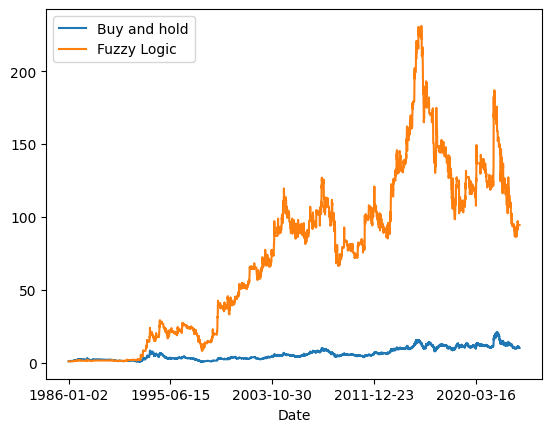

In [7]:
# backtest the strategy
stock.df['trailingstop'] = 0
stock.df['returns'] = 1
stock.df['change'] = stock.df['Close'].pct_change()+1
stock.df['regime'] = 0
has_long_position = False
highest_close = 0
for i in range(0, len(stock.df)-1):
    # check condition for entry
    if (stock.df['z_sum_rolling'][i] >= 50) and has_long_position == False:
        # buy stock in the next day
        stock.df['regime'][i+1] = 1
        buy_price = stock.df['Close'][i+1]
        has_long_position = True
        highest_close = stock.df['Close'][i]

    # establish trailing stop
    if has_long_position == True:
        if stock.df['Close'][i] > highest_close:
            highest_close = stock.df['Close'][i]
        stock.df['trailingstop'][i] = 0.95 * highest_close
    
    # check conditions for exit
    condition1 = stock.df['z_sum_rolling'][i] < 50
    # condition2 = stock.df['Close'][i] < stock.df['trailingstop'][i]
    condition2 = False
    if( (condition1) or (condition2) ) and has_long_position == True:
        stock.df['regime'][i] = -1
        has_long_position = False
        highest_close = 0

# put 1 between 1 and -1 
for i in range(1, len(stock.df)):
    if stock.df['regime'][i-1] == 1 and stock.df['regime'][i] == 0:
        stock.df['regime'][i] = 1

# compute returns
for i in range(0, len(stock.df)):
    if stock.df['regime'][i] != 0:
        stock.df['returns'][i] = stock.df['change'][i]

# compute for the total returns and plot these
stock.df['change'].cumprod().plot(label = 'Buy and hold')
stock.df['returns'].cumprod().plot(label = 'Fuzzy Logic').legend()

# show the percent change of the returns for buy and hold vs fuzzy logic
print(stock.df['change'].cumprod()[-1], stock.df['returns'].cumprod()[-1])